In [426]:
!pip install faker

In [427]:
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt

The module faker is used to create duplicate dates for our dataset

The function format_date to convert those duplicate dates to human readable dates

eg: 2007-03-01 to Mar 1,2007

In [428]:
fake=Faker()
Faker.seed(1)
random.seed(1)

In [429]:
#kinds of human readable dates
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

In [430]:
def load_date():
  """
  to create dates and return them as human readable
  """
  #date_object returns a date betweeen January 1, 1970 and now
  dt=fake.date_object()
  try:
    human_dates=format_date(dt,format=random.choice(FORMATS))
    human_dates=human_dates.lower()
    human_dates=human_dates.replace(",","")
    machine_dates=dt.isoformat()
    #isoformat:'1999-11,13'
  except Exception:
    return None,None,None

  return human_dates,machine_dates,dt


In [431]:
def load_dateset(m):
  """
  to load the dataset for the model
  """
  human_vocab=set()
  machine_vocab=set()
  dataset=[]
  for i in range(m):

    #creating dataset and vocabolaries for machine and human readable dates
    human_dates,machine_dates,_=load_date()
    if human_dates!=None:
      dataset.append((human_dates,machine_dates))
      machine_vocab.update(list(machine_dates))
      human_vocab.update(list(human_dates))
  #checking print(human_vocab)
  #assosiate each character with a item number in both vocaboaries 
  hum=dict(zip(sorted(human_vocab)+['<ukn>','<pad>'],list(range(len(human_vocab)+2))))
  inverse_mac=dict(enumerate(sorted(machine_vocab)))
  mac={ b:a for a,b in inverse_mac.items()}

  return dataset,hum,mac,inverse_mac


In [432]:
#for checking
"""
for i in range(10):
  a,b,c=load_date()
  print(a,"   ",b,"   ",c)

"""

'\nfor i in range(10):\n  a,b,c=load_date()\n  print(a,"   ",b,"   ",c)\n\n'

In [433]:
#for checking
"""
a,b,c,d=load_dateset(10)
a
"""

'\na,b,c,d=load_dateset(10)\na\n'

In [434]:
def softmax(x,axis=1):
  dim=K.ndim(x)
  if dim==2:
    K.softmax(x)
  elif dim > 2:
        #just for speed, the same formula
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
  return K.softmax(x)

In [435]:
def string_to_int(string,length,vocab):
  """
  to convert the characters of a string to their respective indices as in vocablaries
  """
  string=string.lower()
  string=string.replace(",","")
  if len(string)>length:
    string=string[:length]
  replacement=list(map(lambda x: vocab.get(x,'<ukn>'),string))
  if len(string)<length:
    replacement=replacement + [vocab['<pad>']]*(length-len(string))
  return replacement

In [436]:
def int_to_string(ints,inv_vocab):
  """
  inverse version of string to integer
  """
  s=[inv_vocab[i] for i in ints]
  return s

In [437]:
def preprocess(dataset,hum,mac,Tx,Ty):
  """
  preprocess the data to be used while training
  """
  X,Y=zip(*dataset)
  X=np.array([string_to_int(X[i],Tx,hum) for i in range(len(X))])
  Y=[string_to_int(Y[i],Ty,mac) for i in range(len(Y))]
  #onehot encodings 
  Xoh=np.array(list(map(lambda x:to_categorical(x,num_classes=len(hum)),X)))
  Yoh=np.array(list(map(lambda y:to_categorical(y,num_classes=len(mac)),Y)))
  return X,np.array(Y),Xoh,Yoh

In [438]:
m=10000
dataset,human_vocab,machine_vocab,inv_machine_vocab=load_dateset(m)

In [439]:
Tx=30
Ty=10
X,Y,Xoh,Yoh=preprocess(dataset,human_vocab,machine_vocab,Tx,Ty)


In [440]:
Xoh.shape

(10000, 30, 37)

In [441]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.models import load_model, Model

In [442]:
#required layer objects needed to build the attention model

#Attention unit

repeator=RepeatVector(Tx)
concatenator=Concatenate(axis=-1)
densor1=Dense(15,activation='tanh')
densor2=Dense(1,activation='relu')
activator=Activation(softmax,name='acti_weights')
dotor=Dot(axes=1)

In [443]:
def step_attention(a,s_prev):
  #repeat the 1-d s_prev Tx times
  ss=repeator(s_prev)
  #to concatenate activations of post activation lstm and pre-activation lstm
  concat=concatenator([a,ss])
  #intermediate layer for computing energies
  inter_energy=densor1(concat)
  #energies required to compute the alpha values
  energy=densor2(inter_energy)
  #activation softmax
  alphas=activator(energy)
  #dot product to calculate the context
  context=dotor([alphas,a])
  return context


In [444]:
n_a=16 #no of units of pre-activation lstm(bidirectional)
n_s=32 #no of units of post activation lstm

In [445]:
post_activation_lstm_cell=LSTM(n_s,return_state=True)
out_layer=Dense(len(machine_vocab),activation=softmax)

In [446]:
def model(Tx,Ty,n_a,n_s,human_vocab,machine_vocab):
  outputs=[]
  #pre-attention 
  X_input=Input(shape=(Tx,len(human_vocab)))
  a=Bidirectional(LSTM(n_a,return_sequences=True))(X_input)
  
  #post attention
  s0=Input(shape=(n_s,))
  c0=Input(shape=(n_s,))
  s=s0
  c=c0
  for i in range(Ty):
    context=step_attention(a,s)

    #lstm layer for each timestep of output
    s,_,c=post_activation_lstm_cell(context,initial_state=[s,c])
    out=out_layer(s)
    outputs.append(out)
  
  model=Model(inputs=[X_input,s0,c0],outputs=outputs)
     
  return model



In [447]:
model=model(Tx,Ty,n_a,n_s,human_vocab,machine_vocab)

In [448]:
model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 30, 32)       6912        input_42[0][0]                   
__________________________________________________________________________________________________
repeat_vector_8 (RepeatVector)  (None, 30, 32)       0           input_43[0][0]                   
                                                                 lstm_26[0][0]        

In [449]:
opt = Adam(lr=0.005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [450]:
s0=np.zeros((m,n_s))
c0=np.zeros((m,n_s))
outputs = list(Yoh.swapaxes(0,1))

In [451]:
model.fit([Xoh,s0,c0],outputs,batch_size=32,epochs=15)

Epoch 1/15
313/313 [==============================] - 11s 36ms/step - loss: 12.6406 - dense_27_loss: 0.6808 - dense_27_1_loss: 0.5801 - dense_27_2_loss: 1.3778 - dense_27_3_loss: 2.4123 - dense_27_4_loss: 0.3222 - dense_27_5_loss: 0.7922 - dense_27_6_loss: 2.2926 - dense_27_7_loss: 0.3954 - dense_27_8_loss: 1.3903 - dense_27_9_loss: 2.3970 - dense_27_accuracy: 0.7202 - dense_27_1_accuracy: 0.8158 - dense_27_2_accuracy: 0.4274 - dense_27_3_accuracy: 0.1428 - dense_27_4_accuracy: 0.9706 - dense_27_5_accuracy: 0.6248 - dense_27_6_accuracy: 0.1818 - dense_27_7_accuracy: 0.9853 - dense_27_8_accuracy: 0.3649 - dense_27_9_accuracy: 0.1265
Epoch 2/15
313/313 [==============================] - 11s 35ms/step - loss: 4.5427 - dense_27_loss: 0.0420 - dense_27_1_loss: 0.0311 - dense_27_2_loss: 0.3893 - dense_27_3_loss: 0.9666 - dense_27_4_loss: 0.0069 - dense_27_5_loss: 0.1486 - dense_27_6_loss: 1.1487 - dense_27_7_loss: 0.0104 - dense_27_8_loss: 0.7440 - dense_27_9_loss: 1.0552 - dense_27_accuracy

In [452]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
  for_input=np.array([string_to_int(example,30,human_vocab)])
  final_for_input=np.array(list(map(lambda x: to_categorical(x,num_classes=len(human_vocab)),for_input)))
  s0=np.zeros((1,n_s))
  c0=np.zeros((1,n_s))
  prediction=model.predict([final_for_input,s0,c0])
  prediction = np.argmax(prediction, axis = -1)
  output = [inv_machine_vocab[int(i)] for i in prediction]
  print("input:", example)
  print("output:", ''.join(output),"\n")




input: 3 May 1979
output: 1979-05-03 

input: 5 April 09
output: 2009-04-05 

input: 21th of August 2016
output: 2016-08-21 

input: Tue 10 Jul 2007
output: 2007-07-10 

input: Saturday May 9 2018
output: 2018-05-09 

input: March 3 2001
output: 2001-03-03 

input: March 3rd 2001
output: 2001-03-03 

input: 1 March 2001
output: 2001-03-01 



In [453]:
example="may 05th 79 "
for_input=np.array([string_to_int(example,30,human_vocab)])
final_for_input=np.array(list(map(lambda x: to_categorical(x,num_classes=len(human_vocab)),for_input)))
s0=np.zeros((1,n_s))
c0=np.zeros((1,n_s))
prediction=model.predict([final_for_input,s0,c0])
prediction = np.argmax(prediction, axis = -1)

In [454]:
def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
  attention_map=np.zeros((Ty,Tx))
  s0 = np.zeros((1, n_s))
  c0 = np.zeros((1, n_s))
  layer = model.layers[num]
  for_input=np.array([string_to_int(text,Tx,input_vocabulary)])
  final_for_input=np.array(list(map(lambda x: to_categorical(x,num_classes=len(input_vocabulary)),for_input)))
  prediction=model.predict([final_for_input,s0,c0])
  final_prediction=np.argmax(prediction,axis=-1)
  outputs=[inv_output_vocabulary[int(i)] for i in final_prediction]
  

  f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
  r = f([final_for_input, s0, c0])
  for t in range(Ty):
    for tprime in range(Tx):
      attention_map[t][tprime] = r[t][0,tprime,0]
  
  plt.clf()
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(1,1,1)
  i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

  ax.set_xticks(list(range(len(text))))
  ax.set_xticklabels(text)

  ax.set_yticks(list(range(len(outputs))))
  ax.set_yticklabels(outputs)
  cbaxes = fig.add_axes([0.2, 0, 0.6, 0.03])
  cbar = fig.colorbar(i, cax=cbaxes, orientation='horizontal')
  cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)
  ax.grid()



<Figure size 432x288 with 0 Axes>

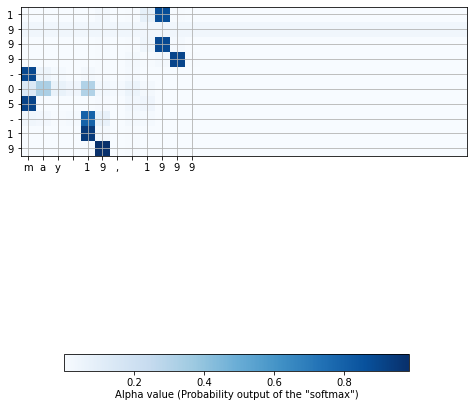

In [455]:
plot_attention_map(model,human_vocab,inv_machine_vocab,'may 19, 1999',n_s,7,Tx,Ty)